In [1]:
!git clone https://github.com/LizaDerb/probing_compositionality/

Cloning into 'probing_compositionality'...
remote: Enumerating objects: 646, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (340/340), done.
remote: Total 646 (delta 127), reused 270 (delta 76), pack-reused 225
Receiving objects: 100% (646/646), 240.12 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (155/155), done.
Updating files: 100% (131/131), done.


# Датасет

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
rus = pd.read_csv('/content/probing_compositionality/data/rus/extended_vp_corpus.csv', sep=';')
rus = rus[['mwe', 'label', 'short_sentence']].rename(columns={'short_sentence' : 'sentence'})
rus.head()

,mwe,label,sentence
0,жирно будет,I,"Нет, о ""пятерке"" говорить конечно даже не прих..."
1,жирно будет,I,"В том роде, как тогда на Фотьянке. Так вот как..."
2,жирно будет,I,"Больше не проси, потому,-- не дам: больно жирн..."
3,жирно будет,I,Отпущу я его на заработки! А самому небось бат...
4,жирно будет,I,"-- Ну, уж слуга покорный! -- огрызнулся Сарма..."


In [4]:
num_idiom = rus['mwe'].value_counts()
idiom_train = num_idiom[:14].index.tolist()
idiom_test = num_idiom[14:].index.tolist()

rus_train = rus[rus['mwe'].isin(idiom_train)]
rus_test = rus[rus['mwe'].isin(idiom_test)]

rus_train = rus_train.dropna()

print('train: ', len(rus_train))
print('test: ', len(rus_test))

train:  830
test:  445


In [5]:
stat_train_rus = rus_train['label'].value_counts().rename('num').to_frame()
stat_train_rus['percentage'] = (stat_train_rus.num * 100 / stat_train_rus.num.sum()).round(1).astype(str) + '%'
stat_train_rus

,num,percentage
label,,
I,488,58.8%
L,342,41.2%


In [6]:
stat_test_rus = rus_test['label'].value_counts().rename('num').to_frame()
stat_test_rus['percentage'] = (stat_test_rus.num * 100 / stat_test_rus.num.sum()).round(1).astype(str) + '%'
stat_test_rus

,num,percentage
label,,
I,263,59.1%
L,182,40.9%


# Модель

In [ ]:
!pip install datasets

In [8]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

In [9]:
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import warnings
import random
import pickle

import torch
from torch.utils.data import DataLoader

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel

In [10]:
train = Dataset.from_pandas(rus_train)
test = Dataset.from_pandas(rus_test)

In [11]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [12]:
train_labels = le.transform(train['label'])
test_labels = le.transform(test['label'])

In [13]:
rubert_tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/bert-base-multilingual-cased-sentence')
rubert = AutoModel.from_pretrained('DeepPavlov/bert-base-multilingual-cased-sentence')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [14]:
torch.cuda.is_available()

True

In [15]:
device_cuda = torch.device("cuda")
device_cpu = torch.device("cpu")

In [16]:
def vectorize_dataset(data, tokenizer, model, num):
    model = model.to(device_cuda)
    res_cls = []
    res_mean = []
    for batch in tqdm(data):
        toks = tokenizer(batch['sentence'], padding='max_length', truncation=True, return_tensors='pt', max_length=300)
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()}, output_hidden_states=True)
            res_cls.append(model_output.hidden_states[num][:,0,:]) #достаём вектора для CLS токенов
            res_mean.append(torch.mean(model_output.hidden_states[num], dim=1)) #среднее
    res_cls = torch.vstack(res_cls)
    res_mean = torch.vstack(res_mean)
    return res_cls.detach().cpu().numpy(), res_mean.detach().cpu().numpy()

In [17]:
dl_train = DataLoader(train, batch_size=256, shuffle=False,
                drop_last=False)
dl_test = DataLoader(test, batch_size=256, shuffle=False,
                drop_last=False)

train_cls = []
train_mean = []
test_cls = []
test_mean = []
for n in range(1, 13):
    vecs_train_cls, vecs_train_mean = vectorize_dataset(dl_train, rubert_tokenizer, rubert, n)
    vecs_test_cls, vecs_test_mean = vectorize_dataset(dl_test, rubert_tokenizer, rubert, n)
    train_cls.append(vecs_train_cls)
    train_mean.append(vecs_train_mean)
    test_cls.append(vecs_test_cls)
    test_mean.append(vecs_test_mean)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
vectors = {'vecs_train_cls' : train_cls, 'vecs_train_mean' : train_mean,
           'vecs_test_cls' : test_cls, 'vecs_test_mean' : test_mean}

for name in vectors.keys():
    with open(f'{name}.pkl', 'wb') as file:
         pickle.dump(vectors[name], file)

In [19]:
vector_names = ['vecs_train_cls', 'vecs_train_mean', 'vecs_test_cls', 'vecs_test_mean']
vecs = []

for name in vector_names:
    with open(f'{name}.pkl', "rb") as fIn:
        vecs.append(pickle.load(fIn))

train_cls = vecs[0]
train_mean = vecs[1]
test_cls = vecs[2]
test_mean = vecs[3]

In [20]:
len(train_cls)

12

In [21]:
train_cls[0].shape

(830, 768)

In [22]:
def calculate_metrics(true_labels, predictions):
    matrix = confusion_matrix(true_labels, predictions)
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)
    return matrix, acc, prec, rec, f1, roc_auc

In [23]:
def get_results(train_data, train_labels, test_data, test_labels):
    results_train = []
    results_test = []
    for n in tqdm(range(12)):
        clf = MLPClassifier(random_state=42, max_iter=300, verbose=1)
        clf.fit(train_data[n], train_labels)
        train_pred = clf.predict(train_data[n])
        test_pred = clf.predict(test_data[n])
        results_train.append(calculate_metrics(train_labels, train_pred))
        results_test.append(calculate_metrics(test_labels, test_pred))
    return results_train, results_test, test_pred

In [ ]:
results_train_mean, results_test_mean, test_pred_mean = get_results(train_mean, train_labels, test_mean, test_labels)
res_test_mean = pd.DataFrame(results_test_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_mean = pd.DataFrame(results_train_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_mean.to_csv('res_test_mean.csv')
res_train_mean.to_csv('res_train_mean.csv')

In [25]:
print(classification_report(test_labels, test_pred_mean, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.82      0.77      0.79       263
           L       0.69      0.76      0.72       182

    accuracy                           0.76       445
   macro avg       0.76      0.76      0.76       445
weighted avg       0.77      0.76      0.77       445



In [26]:
res_train_mean[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.828916,0.840136,0.722222,0.776730,0.812955
1,0.804819,0.731959,0.830409,0.778082,0.808647
2,0.830120,0.946667,0.622807,0.751323,0.799108
3,0.968675,0.984663,0.938596,0.961078,0.964175
4,0.996386,0.994169,0.997076,0.995620,0.996489
5,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
res_test_mean[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.750562,0.698324,0.686813,0.692521,0.740745
1,0.714607,0.615063,0.807692,0.698337,0.728941
2,0.748315,0.761194,0.560440,0.645570,0.719383
3,0.757303,0.703297,0.703297,0.703297,0.748987
4,0.770787,0.715054,0.730769,0.722826,0.764624
5,0.779775,0.725806,0.741758,0.733696,0.773921
6,0.773034,0.712042,0.747253,0.729223,0.769064
7,0.755056,0.679803,0.758242,0.716883,0.755547
8,0.766292,0.689320,0.780220,0.731959,0.768437
9,0.746067,0.669951,0.747253,0.706494,0.746250


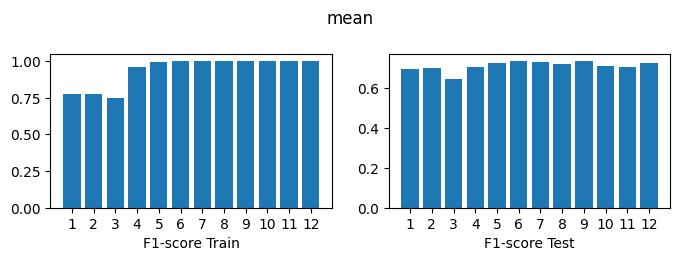

In [28]:
x = range(1, 13)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
ax[0].bar(x, res_train_mean['f1'])
ax[0].set_xlabel('F1-score Train')
ax[0].set_xticks(x, range(1, 13), rotation='horizontal')
ax[1].bar(x, res_test_mean['f1'])
ax[1].set_xlabel('F1-score Test')
ax[1].set_xticks(x, range(1, 13), rotation='horizontal')
fig.suptitle('mean', y=1.1)
plt.show()

In [ ]:
results_train_cls, results_test_cls, test_pred_cls = get_results(train_cls, train_labels, test_cls, test_labels)
res_test_cls = pd.DataFrame(results_test_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_cls = pd.DataFrame(results_train_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_cls.to_csv('res_test_cls.csv')
res_train_cls.to_csv('res_train_cls.csv')

In [30]:
print(classification_report(test_labels, test_pred_cls, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.82      0.79      0.80       263
           L       0.71      0.75      0.73       182

    accuracy                           0.77       445
   macro avg       0.77      0.77      0.77       445
weighted avg       0.78      0.77      0.77       445



In [31]:
res_train_cls[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.784337,0.772575,0.675439,0.720749,0.768047
1,0.786747,0.760252,0.704678,0.731411,0.774470
2,0.809639,0.767442,0.771930,0.769679,0.803998
3,0.830120,0.763780,0.850877,0.804979,0.833225
4,0.989157,0.991150,0.982456,0.986784,0.988154
5,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
res_test_cls[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.739326,0.689655,0.659341,0.674157,0.727009
1,0.728090,0.659686,0.692308,0.675603,0.722580
2,0.755056,0.693122,0.719780,0.706199,0.749624
3,0.764045,0.691542,0.763736,0.725849,0.763997
4,0.748315,0.676768,0.736264,0.705263,0.746459
5,0.755056,0.687179,0.736264,0.710875,0.752162
6,0.755056,0.691099,0.725275,0.707775,0.750470
7,0.750562,0.696133,0.692308,0.694215,0.741591
8,0.761798,0.697917,0.736264,0.716578,0.757866
9,0.743820,0.668317,0.741758,0.703125,0.743503


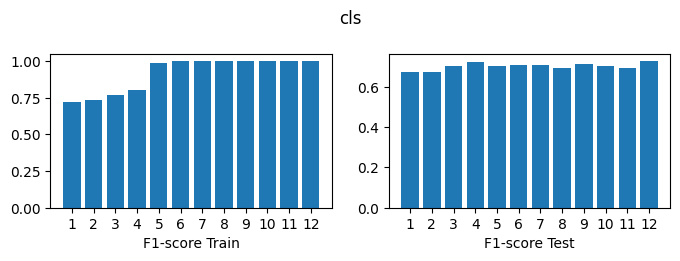

In [33]:
x = range(1, 13)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
ax[0].bar(x, res_train_cls['f1'])
ax[0].set_xlabel('F1-score Train')
ax[0].set_xticks(x, range(1, 13), rotation='horizontal')
ax[1].bar(x, res_test_cls['f1'])
ax[1].set_xlabel('F1-score Test')
ax[1].set_xticks(x, range(1, 13), rotation='horizontal')
fig.suptitle('cls', y=1.1)
plt.show()

In [35]:
!zip -r /content/file.zip /content/layers_rus_mbert

  adding: content/layers_rus_mbert/ (stored 0%)
  adding: content/layers_rus_mbert/res_train_mean.csv (deflated 62%)
  adding: content/layers_rus_mbert/res_train_cls.csv (deflated 61%)
  adding: content/layers_rus_mbert/vecs_test_cls.pkl (deflated 7%)
  adding: content/layers_rus_mbert/res_test_mean.csv (deflated 57%)
  adding: content/layers_rus_mbert/vecs_test_mean.pkl (deflated 8%)
  adding: content/layers_rus_mbert/res_test_cls.csv (deflated 58%)
